# Chapter 6 Linear Model Selection and Regularization

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings


from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
!pip install l0bnb
from l0bnb import fit_path


warnings.filterwarnings('ignore')

8. In this exercise, we will generate simulated data, and will then use this data to perform forward and backward stepwise selection.
- (a) Create a random number generator and use its normal() method to generate a predictor X of length n = 100, as well as a noise vector ε of length n = 100.
- (b) Generate a response vector Y of length n = 100 according to the model
Y =β0 +β1X+β2X2 +β3X3 +ε, where β0, β1, β2, and β3 are constants of your choice.
- (c) Use forward stepwise selection in order to select a model containing the predictors X, X2, . . . , X10. What is the model obtained according to Cp? Report the coefficients of the model obtained.
- (d) Repeat (c), using backwards stepwise selection. How does your answer compare to the results in (c)?
- (e) Now fit a lasso model to the simulated data, again using X,X2, . . . , X 10 as predictors. Use cross-validation to select the optimal value of λ. Create plots of the cross-validation error as a function of λ. Report the resulting coefficient estimates, and discuss the results obtained.
- (f) Now generate a response vector Y according to the model Y = β0 + β7X7 + ε,
and perform forward stepwise selection and the lasso. Discuss the results obtained.

In [23]:
# (a) Create a random number generator and use its normal() method to generate a predictor X of length n = 100, as well as a noise vector ε of length n = 100.

rng = np.random.default_rng(42)
x1 = rng.normal(12, 2, 100)
x2 = rng.normal(-25, 3, 100)
x3 = rng.normal(3, 6, 100)
x4 = rng.normal(5, 1, 100)
x5 = rng.normal(5, 1, 100)
x6 = rng.normal(5, 1, 100)
x7 = rng.normal(5, 1, 100)
x8 = rng.normal(4, 1, 100)
x9 = rng.normal(5, 1, 100)
x10  = rng.normal(5, 6, 100) 
e = rng.normal(0, 3, 100)


In [32]:
# (b) Generate a response vector Y of length n = 100 according to the model Y =β0 +β1X+β2X2 +β3X3 +ε, where β0, β1, β2, and β3 are constants of your choice.

b0 = 5
b1 = -3
b2 = 2
b3 = 12

Y = b0 + b1*x1 + b2*x2 + b3*x3 + e

In [33]:
# (c) Use forward stepwise selection in order to select a model containing the predictors X, X2, . . . , X10. What is the model obtained according to Cp? Report the coefficients of the model obtained.

X = pd.DataFrame({'x1': x1,
                  'x2': x2,
                  'x3': x3,
                  'x4': x4,
                  'x5': x5,
                  'x6': x6,
                  'x7': x7,
                  'x8': x8,
                  'x9': x9,
                  'x10': x10
                 })

def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n 

# We need to estimate the residual variance, which is the first argument in our scoring function above. We will fit the biggest model, using all the variables, and estimate based on its MSE.

design = MS(X).fit(X)
Y = np.array(Y)
X = design.transform(X)
sigma2 = OLS(Y,X).fit().scale

neg_Cp = partial(nCp, sigma2)

strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

In [34]:
MSE = sklearn_selected(OLS, strategy)
MSE.fit(X, Y)
MSE.selected_state_

('x1', 'x10', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9')

In [35]:
Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
Cp.fit(X, Y)
Cp.selected_state_

('x1', 'x2', 'x3')

In [41]:
# (d) Repeat (c), using backwards stepwise selection. How does your answer compare to the results in (c)?

strategy = Stepwise.first_peak(design,
                               direction='backwards',
                               max_terms=len(design.terms))

Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
Cp.fit(X, Y)
Cp.selected_state_

('x1', 'x2', 'x3')

In [42]:
# (e) Now fit a lasso model to the simulated data, again using X,X2, . . . , X 10 as predictors. Use cross-validation to select the optimal value of λ. Create plots of the cross-validation error as a function of λ. Report the resulting coefficient estimates, and discuss the results obtained.

D = design.fit_transform(X)
D = D.drop('intercept', axis=1)
X_ = np.asarray(D)

Xs = X_ - X_.mean(0)[None,:]
X_scale = X_.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=1.,
                                 alphas=lambdas)[1]
soln_array.shape


(10, 100)

In [43]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
negative log(lambda),,,,,,,,,,
-14.129973,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
-13.897388,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
-13.664804,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
-13.432220,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
-13.199635,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
7.965541,-4.817768,5.743051,72.444454,-0.150743,-0.133521,0.253965,0.026427,-0.089114,-0.121681,0.340661
8.198125,-4.817880,5.743113,72.444532,-0.150807,-0.133678,0.254028,0.026564,-0.089195,-0.121718,0.340703
8.430710,-4.817969,5.743161,72.444594,-0.150859,-0.133802,0.254078,0.026672,-0.089259,-0.121748,0.340737


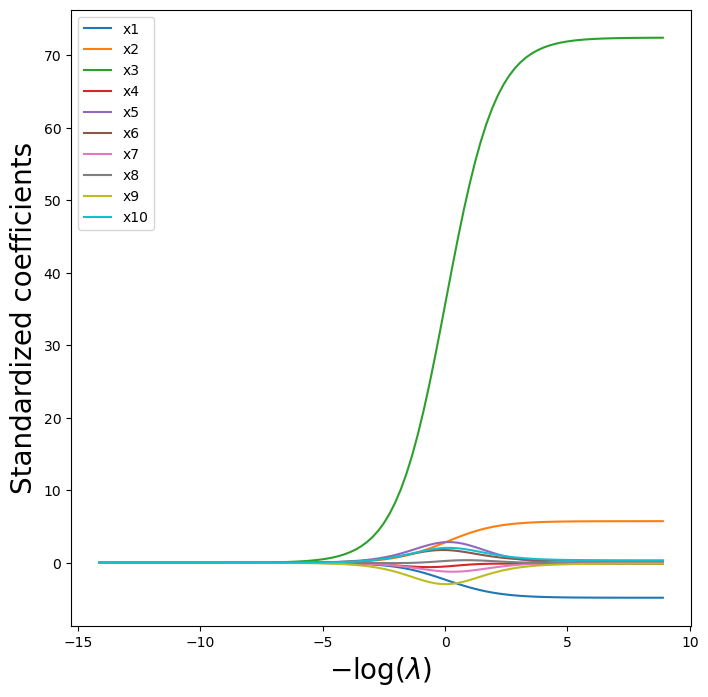

In [39]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

In [ ]:
# (f) Now generate a response vector Y according to the model Y = β0 + β7X7 + ε, and perform forward stepwise selection and the lasso. Discuss the results obtained.






---

9. In this exercise, we will predict the number of applications received using the other variables in the College data set.
- (a) Split the data set into a training set and a test set.
- (b) Fit a linear model using least squares on the training set, and report the test error obtained.
- (c) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.
- (d) Fit a lasso model on the training set, with λ chosen by cross- validation. Report the test error obtained, along with the num- ber of non-zero coefficient estimates.
- (e) Fit a PCR model on the training set, with M chosen by cross- validation. Report the test error obtained, along with the value of M selected by cross-validation.
- f) Fit a PLS model on the training set, with M chosen by cross- validation. Report the test error obtained, along with the value of M selected by cross-validation.
- (g) Comment on the results obtained. How accurately can we pre- dict the number of college applications received? Is there much difference among the test errors resulting from these five ap- proaches?

---

10. We have seen that as the number of features used in a model increases, the training error will necessarily decrease, but the test error may not. We will now explore this in a simulated data set.
- (a) Generate a data set with p = 20 features, n = 1,000 observa- tions, and an associated quantitative response vector generated according to the model
Y =Xβ+ε,
where β has some elements that are exactly equal to zero.
- (b) Splityourdatasetintoatrainingsetcontaining100observations and a test set containing 900 observations.
- (c) Perform best subset selection on the training set, and plot the training set MSE associated with the best model of each size.
- (d) Plot the test set MSE associated with the best model of each size.
- (e) For which model size does the test set MSE take on its minimum value? Comment on your results. If it takes on its minimum value for a model containing only an intercept or a model containing all of the features, then play around with the way that you are generating the data in (a) until you come up with a scenario in which the test set MSE is minimized for an intermediate model size.
- (f) How does the model at which the test set MSE is minimized compare to the true model used to generate the data? Comment on the coefficient values.􏰡􏰎
- (g) Create a plot displaying pj=1(βj − βˆjr)2 for a range of values
of r, where βˆjr is the jth coefficient estimate for the best model containing r coefficients. Comment on what you observe. How does this compare to the test MSE plot from (d)?

---

11. We will now try to predict per capita crime rate in the Boston data set.
- (a) Try out some of the regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression, and PCR. Present and discuss results for the approaches that you consider.
- (b) Propose a model (or set of models) that seem to perform well on this data set, and justify your answer. Make sure that you are evaluating model performance using validation set error, cross-validation, or some other reasonable alternative, as opposed to using training error.
- (c) Does your chosen model involve all of the features in the data set? Why or why not?

---